In [35]:
import plaidml.keras
import os
plaidml.keras.install_backend()
os.environ['KERAS_BACKEND'] = 'plaidml.keras.backend'
import keras

In [36]:
import cv2, os, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [37]:
from glob import glob
from keras.preprocessing import image
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Nadam
from sklearn.model_selection import train_test_split

In [4]:
seed = 2020
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:
path = 'dataset/dogs-vs-cats/train'

In [6]:
ROW, COL = 96, 96

dogs, cats = [], []
y_dogs, y_cats = [], []

In [7]:
def load_img(label):
    load_path = os.path.join(path, label+'.*')
    for load_img in glob(load_path):
        load = cv2.imread(load_img)
        load = cv2.cvtColor(load, cv2.COLOR_BGR2GRAY)
        load = cv2.resize(load, (ROW, COL))
        load = image.img_to_array(load)
        if label == 'dog':
            dogs.append(load)
        else:
            cats.append(load)
    
    print('All %s images loaded'%label)

In [8]:
def shows(label):
    plt.figure(figsize=(12, 8))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        img = image.array_to_img(random.choice(label))
        plt.imshow(img, cmap=plt.get_cmap('gray'))
        plt.axis('off')

    plt.show()

In [9]:
load_img('dog')

All dog images loaded


In [10]:
load_img('cat')

All cat images loaded


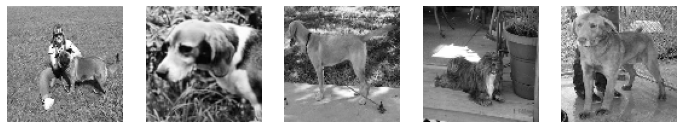

In [11]:
shows(dogs)

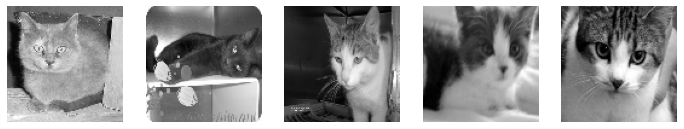

In [12]:
shows(cats)

In [13]:
y_dogs = [1 for item in enumerate(dogs)]
y_cats = [0 for item in enumerate(cats)]

In [14]:
dogs = np.asarray(dogs).astype('float32') / 255
cats = np.asarray(cats).astype('float32') / 255
y_dogs = np.asarray(y_dogs).astype('int32')
y_cats = np.asarray(y_cats).astype('int32')

In [15]:
dogs.shape, y_dogs.shape

((12500, 96, 96, 1), (12500,))

In [16]:
x_data = np.concatenate((dogs, cats), axis = 0)
y_data = np.concatenate((y_dogs, y_cats), axis = 0)

In [17]:
y_data = tf.keras.utils.to_categorical(y_data, 2)

In [18]:
x_train, x_test, y_train, t_test = train_test_split(x_data, y_data, test_size=0.2, random_state = seed)

In [19]:
model = Sequential([
    Conv2D(32, (3,3), padding='same', input_shape=(ROW, COL, 1),  activation='relu'),
    Conv2D(32, (3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(.25),
    
    Conv2D(64, (3,3), padding='same', activation='relu'),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(.25),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(.5),
    Dense(2, activation='softmax')
])

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 64)        0         
__________

In [38]:
model.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

In [39]:
modelpath = "../model/dogsvscats-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = keras.callbacks.ModelCheckpoint(modelpath,verbose=1, save_best_only=True)

In [ ]:
history = model.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=32, callbacks=[checkpointer])

Train on 16000 samples, validate on 4000 samples
Epoch 1/10
16000/16000 [==============================] - 65s 4ms/step - loss: 0.6930 - acc: 0.5071 - val_loss: 0.6878 - val_acc: 0.5647

Epoch 00001: val_loss improved from inf to 0.68781, saving model to ../model/dogsvscats-01-0.6878.hdf5
Epoch 2/10
16000/16000 [==============================] - 65s 4ms/step - loss: 0.6637 - acc: 0.6005 - val_loss: 0.6269 - val_acc: 0.6663

Epoch 00002: val_loss improved from 0.68781 to 0.62693, saving model to ../model/dogsvscats-02-0.6269.hdf5
Epoch 3/10
16000/16000 [==============================] - 66s 4ms/step - loss: 0.6198 - acc: 0.6593 - val_loss: 0.5892 - val_acc: 0.6895

Epoch 00003: val_loss improved from 0.62693 to 0.58916, saving model to ../model/dogsvscats-03-0.5892.hdf5
Epoch 4/10
16000/16000 [==============================] - 66s 4ms/step - loss: 0.5887 - acc: 0.6936 - val_loss: 0.5776 - val_acc: 0.7033

Epoch 00004: val_loss improved from 0.58916 to 0.57759, saving model to ../model/d

In [ ]:
del model

In [ ]:
model = keras.models.load_model('../model/dogsvscats-09-0.6930.hdf5')

In [ ]:
model.evaluate(x_test , t_test, verbose=0)